This notebook explores and visualizes the following data-challenge dataset.

The data we are using was a part of the [ML4Jets 2021 data challenge](https://indico.cern.ch/event/980214/contributions/4413658/attachments/2278124/3870358/ml4jets_data_challenge.pdf). It is publically available in `.h5` format so it's great for testing out new methods!

**Publication:**

E. Govorkova, E. Puljak, T. Aarrestad, M. Pierini, K. A. Woźniak and J. Ngadiuba, LHC physics dataset for unsupervised New Physics detection at 40 MHz, Sci. Data 9, 118 (2022),
doi:[10.1038/s41597-022-01187-8](https://www.nature.com/articles/s41597-022-01187-8), arXiv:2107.02157

**Data:**

NOTE: The original data had several bugs in it. The links in the original materials (i.e. publication and slides) point to the incorrect Version 1 of the data. Version 2 should be used instead. [This website](https://mpp-hep.github.io/ADC2021/) contains the correct links/descriptions/usage information.

- `background_for_training.h5`: 4 million Standard Model (SM) background "training" data ([link to data](https://zenodo.org/record/5046428#.ZB9yKezMKHu))
-  `Ato4l_lepFilter_13TeV_filtered.h5`: # Neutral scalar boson events, $A \rightarrow 4l$, mass = $50$ GeV ([link to data](https://zenodo.org/record/7152590#.ZB9yROzMKHu))
- `leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5`: # Leptoquark events, ${\rm LQ} \rightarrow b \tau$ ([link to data](https://zenodo.org/record/7152599#.ZB9yZOzMKHu))
- `hToTauTau_13TeV_PU20_filtered.h5`: # Scalar boson events, $h^0 \rightarrow \tau \tau$ ([link to data](https://zenodo.org/record/7152614#.ZB9ybOzMKHt))
- `hChToTauNu_13TeV_PU20_filtered.h5`: # Charged scalar boson events, $h^\pm \rightarrow \tau \nu$ ([link to data](https://zenodo.org/record/7152617#.ZB9yf-zMKHt))
- `BlackBox_background_mix.h5`: # Mystery events ([link to data](https://zenodo.org/record/5072068#.ZB9yk-zMKHt))

In [ ]:
sigAliasList    = ['sig_A', 'sig_h0', 'sig_hch', 'sig_LQ']
sigFilenameList = ['Ato4l_lepFilter_13TeV_filtered.h5', 'hToTauTau_13TeV_PU20_filtered.h5', 'hChToTauNu_13TeV_PU20_filtered.h5', 'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5']

# Some thoughts on usage and impact of applying Optimal Transport (OT)

Note the intention for this dataset was to be used to develop methods that could work at Trigger Level:

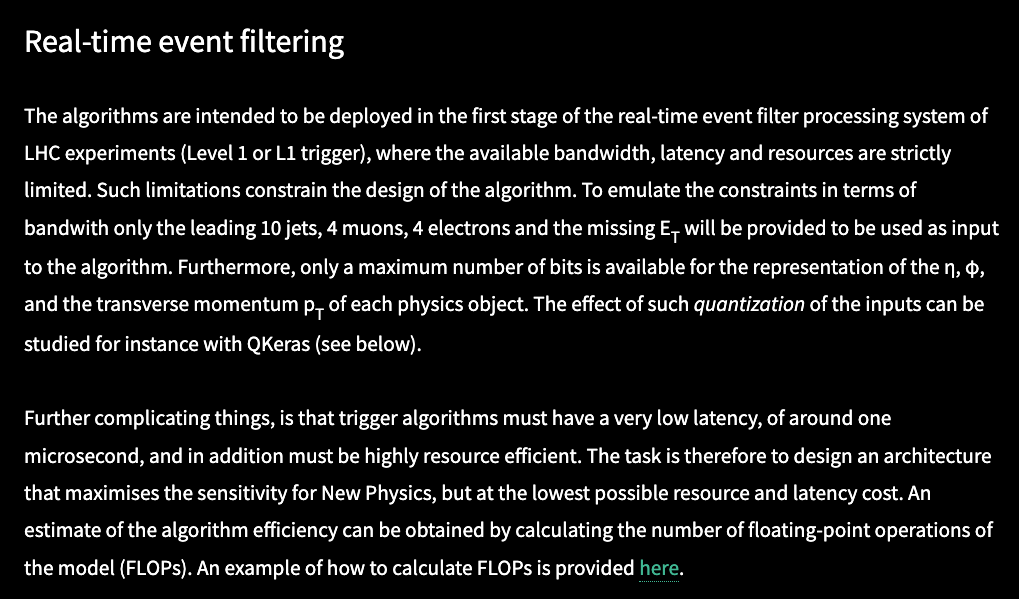

Pre-trained ML methods like Autoencoders would only need to be evaluated event-to-event. Thus, their cost is simply the cost to store their trained architecture and evaluate it in the forward direction.

The question is how Optimal Transport (OT) would compare? Here, you would need to store some number, $N$, of representative background events. Then, for each event, you would need to calculate $N$ OT distances. A priori this might mean that OT is only suitable for off-line anomaly detection.

Two strategies to speed this up that might be worth investigating:

**1.   Linearized OT:**

Here, we would store the linearized embedding of the $N$ representative background events (calculated with respect to some reference event). We would then only need to calculate

*   1 OT distance between the event at hand and the reference event
*   $N$ euclidean distances (between the event and each of the $N$ embedded background events

**2. Predefine a manifold of background events, calculate OT distance to it:**

Assuming that the events will be off-manifold, if we can do this then we need to only do one OT distance calculation (from the event to the manifold).

Alternatively, we can just vies this as a ready-to-go dataset of high-level objects and assume OT will be applied off-line (which aleviates the memory and computational constraints greatly).

# Google Drive preliminaries (since we're running on Google Colab)

In [ ]:
#-- "Mount" Google Drive to access data and save files/images --#
# NOTE: If running locally, comment out this cell and change the basePath accordingly
# Reference: https://stackoverflow.com/questions/49031798/when-i-use-google-colaboratory-how-to-save-image-weights-in-my-google-drive
from google.colab import drive
drive.mount('/content/gdrive')

# You will be asked to sign into a Google account and give GoogleColab access

Mounted at /content/gdrive


In [ ]:
# To check that mounting worked, uncomment and run the following. You should see the contents of the directory listed.
! ls '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/Data/'

Ato4l_lepFilter_13TeV_filtered.h5
background_for_training.h5
BlackBox_background_mix.h5
hChToTauNu_13TeV_PU20_filtered.h5
hToTauTau_13TeV_PU20_filtered.h5
leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5
OldBuggedDatasets


In [ ]:
#-- Set base directory and data directory path --#
basePath   = '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/'
dataPath   = 'Data/'

bkgPath    = basePath+dataPath+'background_for_training.h5'
sigPathList = []
for x in sigFilenameList:
  sigPathList.append(basePath+dataPath+x)

# Import libraries

We'll eventually be using the PyOT library to compute Wasserstein distances for now (see [here](https://pythonot.github.io/index.html)). But since this notebook is just visualizing the data we won't use it yet.

In [ ]:
import numpy as np
from numpy.random import RandomState
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import h5py
from numpy.random import Generator, PCG64
from sklearn import metrics
import itertools

# Functions

To keep things tidy, functions are externally defined in `centralFunctions.ipynb`. We run this notebook from here which defines the contained functions as if they were written here.


In [ ]:
%cd /content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/
%run centralFunctions.ipynb

/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 18.0 MB/s eta 0:00:00


# Load data

In [ ]:
dataDict = {}
dataDict['bkg'] = h5py.File(bkgPath, 'r')

for i in range(len(sigAliasList)):
  alias   = sigAliasList[i]
  sigPath = sigPathList[i]
  dataDict[alias] = h5py.File(sigPath, 'r')

In [ ]:
print("Background Keys in file (f_bkg := dataDict['bkg']):")
for key in dataDict['bkg'].keys():
  print("  ",key)
  print("      f_bkg[%s]"%key)
  print("           .shape: ", dataDict['bkg'][key].shape)
  print("           .dtype: ", dataDict['bkg'][key].dtype)

for alias in sigAliasList:
  print("")
  print("Signal Keys in file (f_sig := dataDict['%s']):"%alias)
  for key in dataDict[alias].keys():
    print("  ",key)
    print("      f_sig[%s]"%key)
    print("           .shape: ", dataDict[alias][key].shape)
    print("           .dtype: ", dataDict[alias][key].dtype)

Background Keys in file (f_bkg := dataDict['bkg']):
   Particles
      f_bkg[Particles]
           .shape:  (13451915, 19, 4)
           .dtype:  float64
   Particles_Classes
      f_bkg[Particles_Classes]
           .shape:  (4,)
           .dtype:  |S16
   Particles_Names
      f_bkg[Particles_Names]
           .shape:  (4,)
           .dtype:  |S5

Signal Keys in file (f_sig := dataDict['sig_A']):
   Particles
      f_sig[Particles]
           .shape:  (55969, 19, 4)
           .dtype:  float64
   Particles_Classes
      f_sig[Particles_Classes]
           .shape:  (4,)
           .dtype:  |S16
   Particles_Names
      f_sig[Particles_Names]
           .shape:  (4,)
           .dtype:  |S5

Signal Keys in file (f_sig := dataDict['sig_h0']):
   Particles
      f_sig[Particles]
           .shape:  (691283, 19, 4)
           .dtype:  float64
   Particles_Classes
      f_sig[Particles_Classes]
           .shape:  (388,)
           .dtype:  |S16
   Particles_Names
      f_sig[Particles_N

This indicates that there are 3 datasets in each file. The first dataset array is the actual data information (see table below).

Let the data be represented by $X$. The information for the $i^{\rm th}$ event is given by $X[i, :, :]$. This is the "face" of the 3D table below. The vertical axis on the "face" is 19 dimensional (${\rm MET}, (e/ \gamma)_i, \mu_j, {\rm jet}_k$ where $i, j = 1, ..., 4$ and $k=1, ..., 10$). The horizontal axis is 4 dimensional. It contains the $p_{\rm T}, \eta, \phi$ information as well as the class information (1, 2, 3 and 4 for MET, electron, muon and jet, respectively).

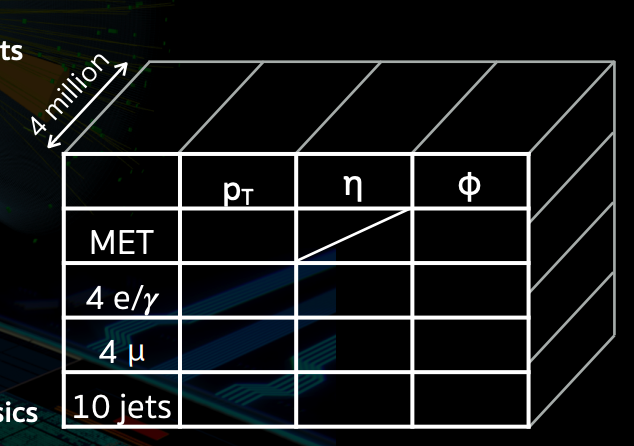

**Description from [the paper](https://www.nature.com/articles/s41597-022-01187-8)**:


*The data records are provided in Hierarchical Data Format version 5 (HDF5), and contain 3 datasets: “Particles”, “Particles_Classes” and “Particles_Names.*

*The dataset “Particles” has a shape (N, 19, 4), where N is the number of events listed for each sample in Table 1. The second index runs over the different physics objects in the events: MET, 4 electrons, 4 muons, 10 jets. Its cardinality (19) is the maximum number of objects per event. If fewer objects are present, the event is zero padded in such a way that the 1st, 5th, and 9th positions correspond to the highest-pT electron, muon, and jet, respectively.*

*The last index (with cardinality 4) runs over the three features describing each physics object and a particle type index, which is equal to 1, 2, 3 and 4 for MET, electron, muon and jet, respectively.*

*The information of which particle kind corresponds to which index value is contained in the “Particle_Classes” dataset, in the form of a single-entry array of strings. Zero padding is done inclusively, e.g. for zero-padded particles the particle type index is set to zero. The features are ordered as described in the “Particles_Names” dataset: pT, η, ϕ.*

*The blackbox sample includes an additional dataset (“EvtId”) with dimension (N), containing an event ID which allows us to match each event to its ground truth (signal or background)."*


$
\space
$

---

$
\space
$


Therefore, the event data we will use is has the shape (N, 19, 3). Where the $i^{th}$ event can be accessed via

```
EventData[i,:,:]
```
And will have shape (19,3). This event could be flattened to represent a point in 19*3 dimensional space. However, it's probably more natural to think of each event as being a collection of 19 particles living in 3D space. Note that events are zero-padded. So a non-existent particle lives at the origin in this 3D space.

In [ ]:
print("Event 0 Raw data:")
print(dataDict['bkg']['Particles'][0, :, :])
print("")
print("Event 0 processed:")
print(dataDict['bkg']['Particles'][0, :, 0:3])
print("")
print("Event 0 particle labels:")
print(dataDict['bkg']['Particles'][0, :, -1])

Event 0 Raw data:
[[27.41296387  0.         -2.0499022   1.        ]
 [24.20996857  1.63350999 -0.10349621  2.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]

Event 0 pro

So background event 0 contains one MET, no electrons, one muon, and one jet.

In [ ]:
print("Particles_Classes: ")
for i in range(4):
  print(dataDict['bkg']["Particles_Classes"][i])
print("")

print("Particles_Names: ")
for i in range(4):
  print(dataDict['bkg']["Particles_Names"][i])

Particles_Classes: 
b'MET_class_1'
b'Four_Ele_class_2'
b'Four_Mu_class_3'
b'Ten_Jet_class_4'

Particles_Names: 
b'Pt'
b'Eta'
b'Phi'
b'Class'


# Data Exploration

## Plot some axes of raw data

We'll plot the MET object's PT, eta, phi for all events for all signal types.

In [ ]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

In [ ]:
# Prepare object data for plotting
objectBkg = dataDict['bkg']['Particles'][:, 0, :]

objectSigList = []
for alias in sigAliasList:
  objectSigList.append(dataDict[alias]['Particles'][:, 0, :])

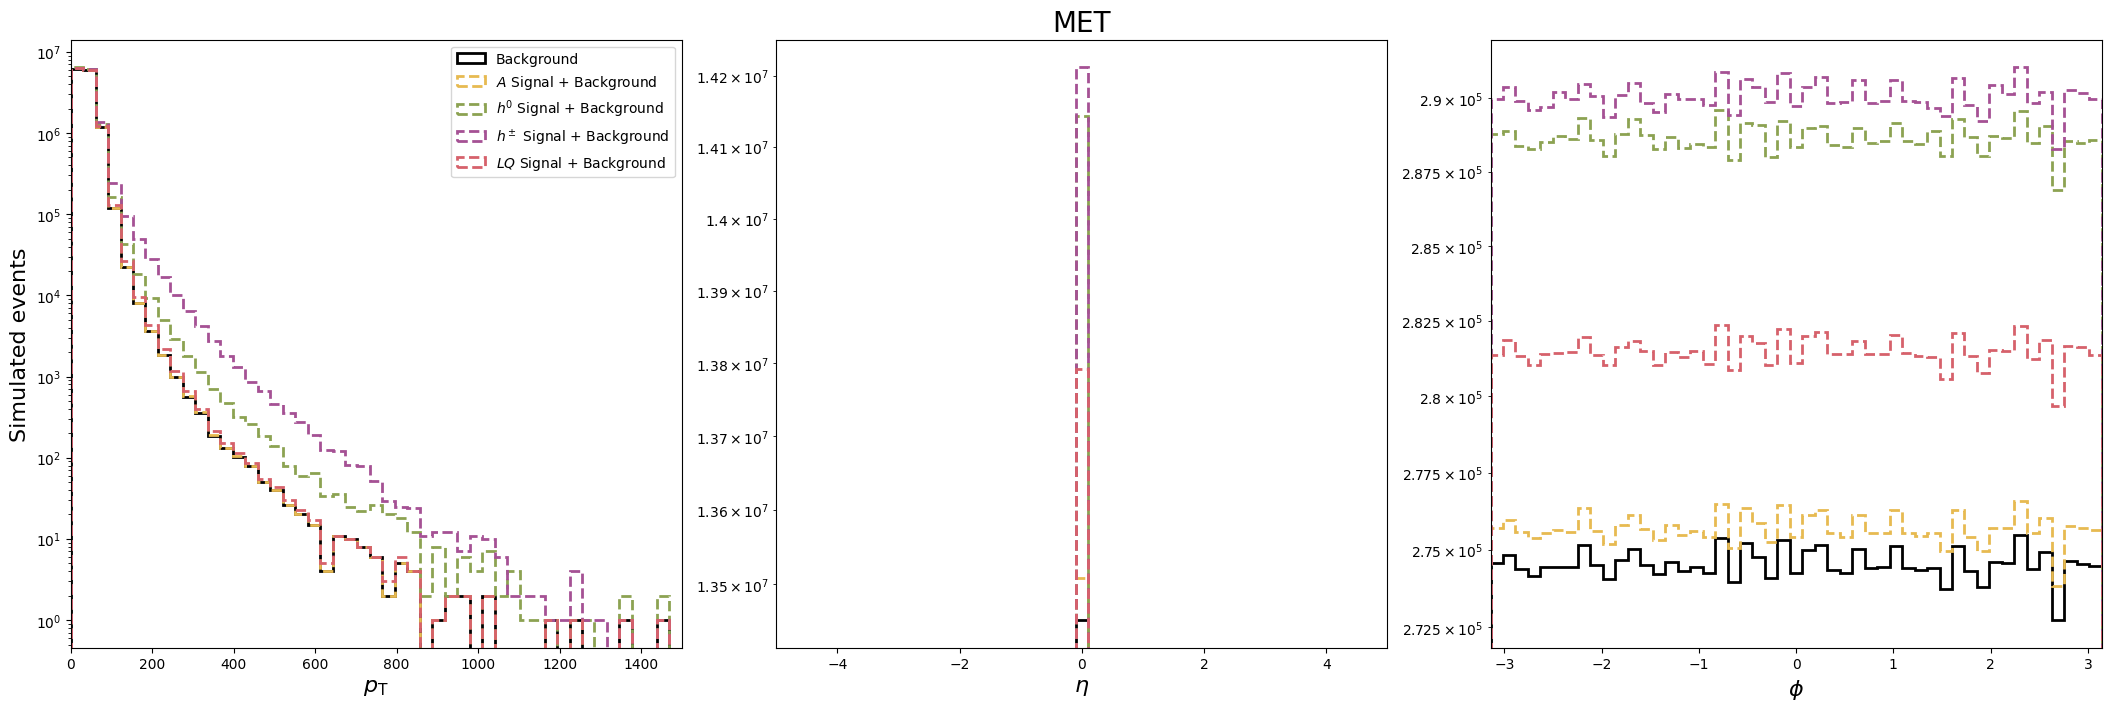

In [ ]:
# Make plot
plotArgDict = {}
plotArgDict['pltDim']             = (1,3) # i.e. 1 row, 3 columns
plotArgDict['xAxisLimsList']      = [(0, 1500), (-5, 5), (-np.pi, np.pi)]
plotArgDict['title']              = r'MET'
plotArgDict['nBins']              = 50
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotDataHists(objectBkg, objectSigList, plotArgDict)

## Plot multiplicities of different categories for Signal vs Background

As pointed out [in this paper](https://arxiv.org/pdf/2301.04660.pdf), the multiplicity of different types of objects can potentially be a good indicator of whether that event is background or some kind of signal. There are 3 object types which can have varying multiplicity: $e$, $\mu$, and ${\rm jet}$. Here we'll plot the multiplicity (i.e. number of _) in each type for background and each signal categories.

In [ ]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

In [ ]:
# Prepare object data for plotting
objectsBkg = dataDict['bkg']['Particles'][:, :, 0] # Only need pT data

objectsSigList = []
for alias in sigAliasList:
  objectsSigList.append(dataDict[alias]['Particles'][:, :, 0]) # Only need pT data

multBkgList, multSigList = calcMultiplicityData(objectsBkg, objectsSigList)

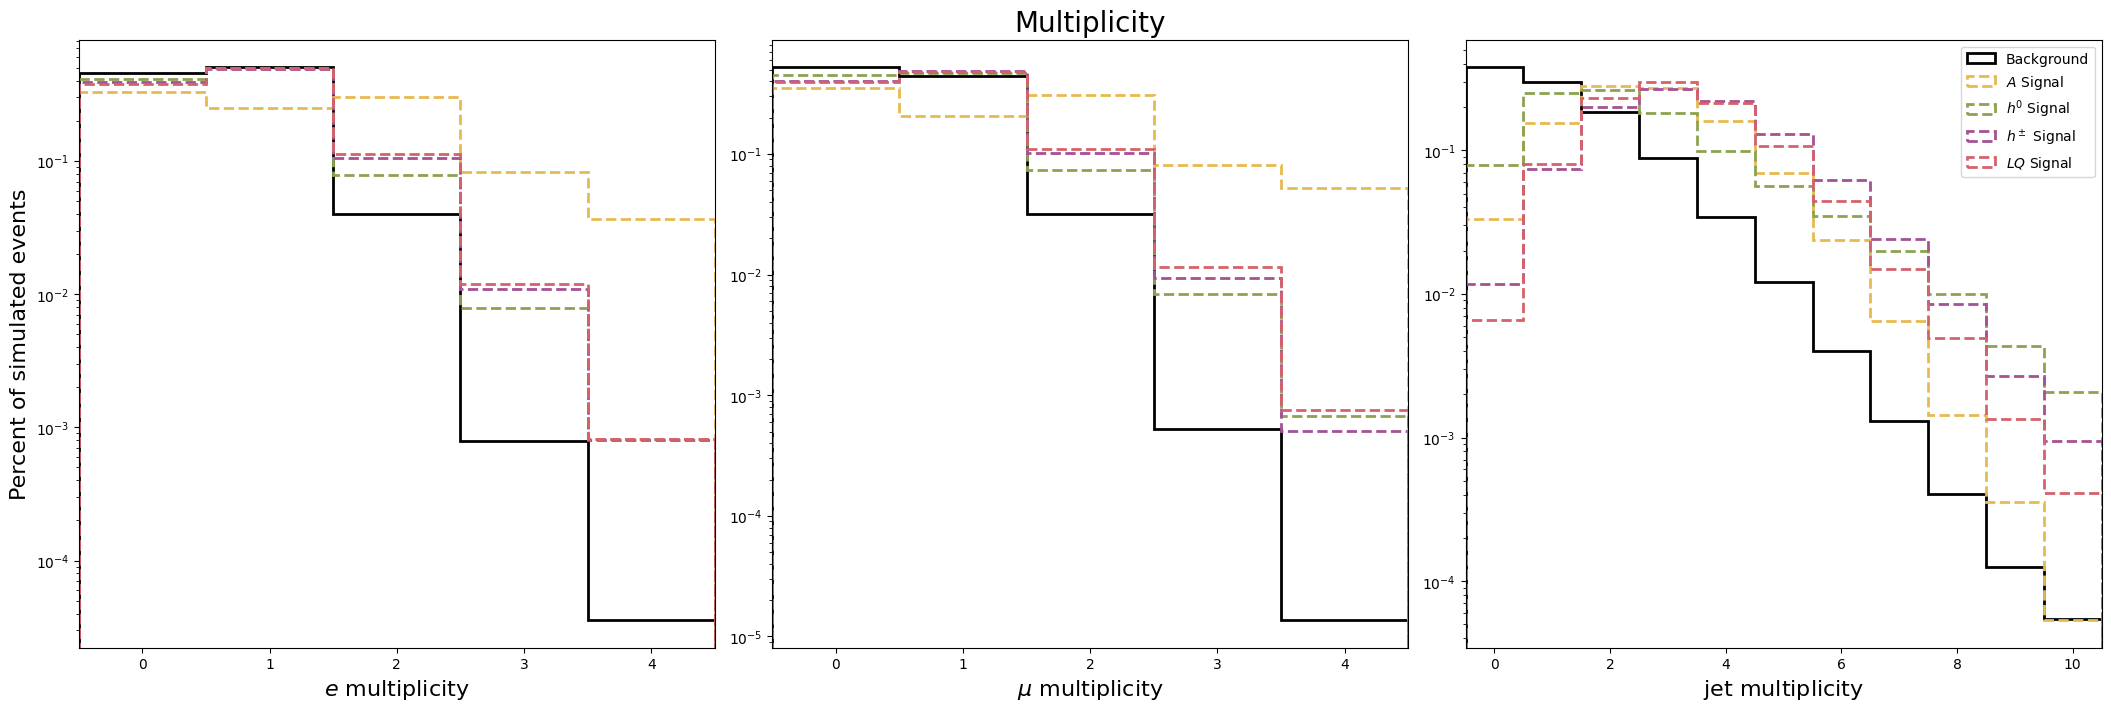

In [ ]:
# Make plot
plotArgDict = {}
plotArgDict['pltDim']             = (1,3) # i.e. 1 row, 3 columns
plotArgDict['xAxisLimsList']      = [(-0.5, 4.5), (-0.5, 4.5), (-0.5, 10.5)]
plotArgDict['title']              = r'Multiplicity'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotMultiplicityData(multBkgList[0:3], multSigList[0:3], plotArgDict)

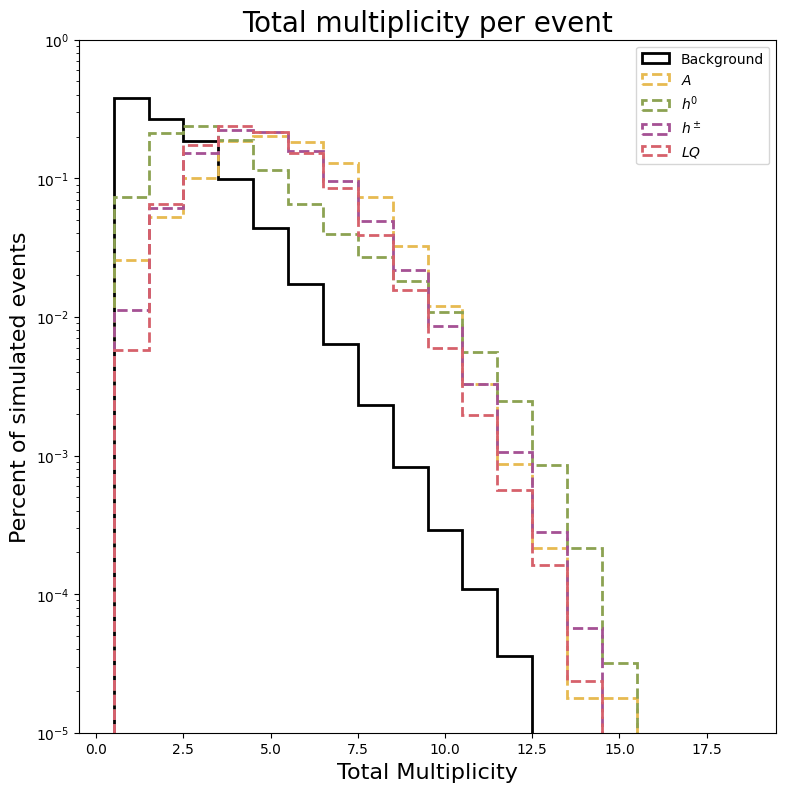

In [ ]:
# Make total multiplicity plot
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (-0.5, 19.5)
plotArgDict['xLabel']             = r'Total Multiplicity'
plotArgDict['yAxisLims']          = (1e-5, 1)
plotArgDict['yLabel']             = 'Percent of simulated events'
plotArgDict['title']              = r'Total multiplicity per event'
plotArgDict['nBins']              = 21
plotArgDict['logY']               = True
plotArgDict['density']            = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(multBkgList[3], multSigList[3], plotArgDict)

## We can also plot the total $p_T$ in an event for Signal vs Background

In [ ]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

In [ ]:
# Prepare object data for plotting
totPtBkg = np.sum(dataDict['bkg']['Particles'][:, :, 0], axis=1)

totPtSigList = []
for alias in sigAliasList:
  totPtSigList.append(np.sum(dataDict[alias]['Particles'][:, :, 0], axis=1))

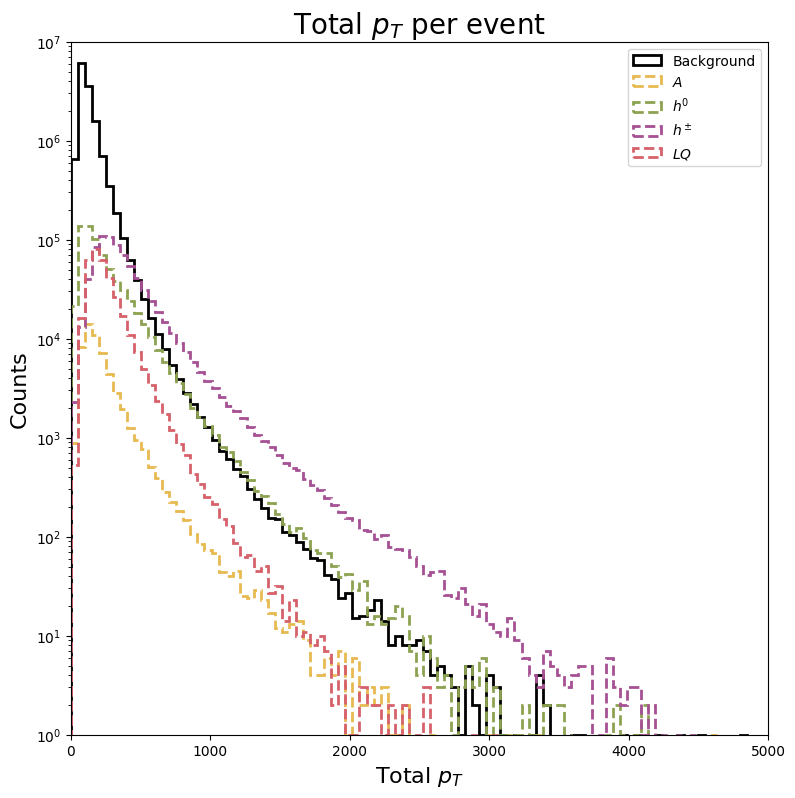

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 5000)
plotArgDict['xLabel']             = r'Total $p_T$'
plotArgDict['yAxisLims']          = (1, 1e7)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r'Total $p_T$ per event'
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(totPtBkg, totPtSigList, plotArgDict)

# Main idea overview: How will we be applying OT?

Each event is a set of 19 objects (MET, 4 $e/\gamma$, 4 $\mu$, 10 jets) with some properties ($p_{\rm T}, \eta, \phi$). Collectively, this defines an *event*. When an object is not present in an event, its $(p_{\rm T}, \eta, \phi) = (0,0,0)$. Thus an event has the shape $(1, 19, 3)$.

From this base definition, we can consider many variants. For example, we could remove all missing objects (i.e. remove all (0,0,0) rows from each event), which would cause the multiplicity of objects to vary event-to-event. We could also add label information based on the type of particles.

<!-- $\color{magenta}{\text{For now, we will visualize each event as comprising 19 point-objects (ignoring their type) located in 3D space.}}$ -->

We can then calculate the OT distance between two events

$$
\text{OT(event[i], event[j])}.
$$

Each event can be viewed as being drawn from a high-dimensional probability distribution defining that event's *class* (i.e. Standard Model background or new physics signal).

The fundamental idea is that the OT distance will cluster events from the same class together, and separate events from different classes.

In this way we can use the OT distance as an anomaly score.

<!-- $\color{magenta}{\text{We assume that our ground space OT cost function is the typical $| \cdot - \cdot|^2$ calculated in 3D ($p_{\rm T}, \eta, \phi$) space.}}$ -->

##### ***Concrete example:***

Consider 3 events: A, B, and C. And assume that events A and B belong to the Standard Model (SM) class while event C belongs to the new physics class. Then the following should be true:

$$
\text{OT(eventA, eventB)} \approx 0 \\
\text{OT(eventA, eventC)} \approx \text{OT(eventB, eventC)} ≫ 0
$$

In other words, events from the same class will ideally have inter-OT distances clustered around $\approx$ 0. While events from different classes will have inter-OT distances clustered around some non-zero value.

Since the OT distance is reflexive we can visualize this as an upper triangular matrix (see the schematic description below)

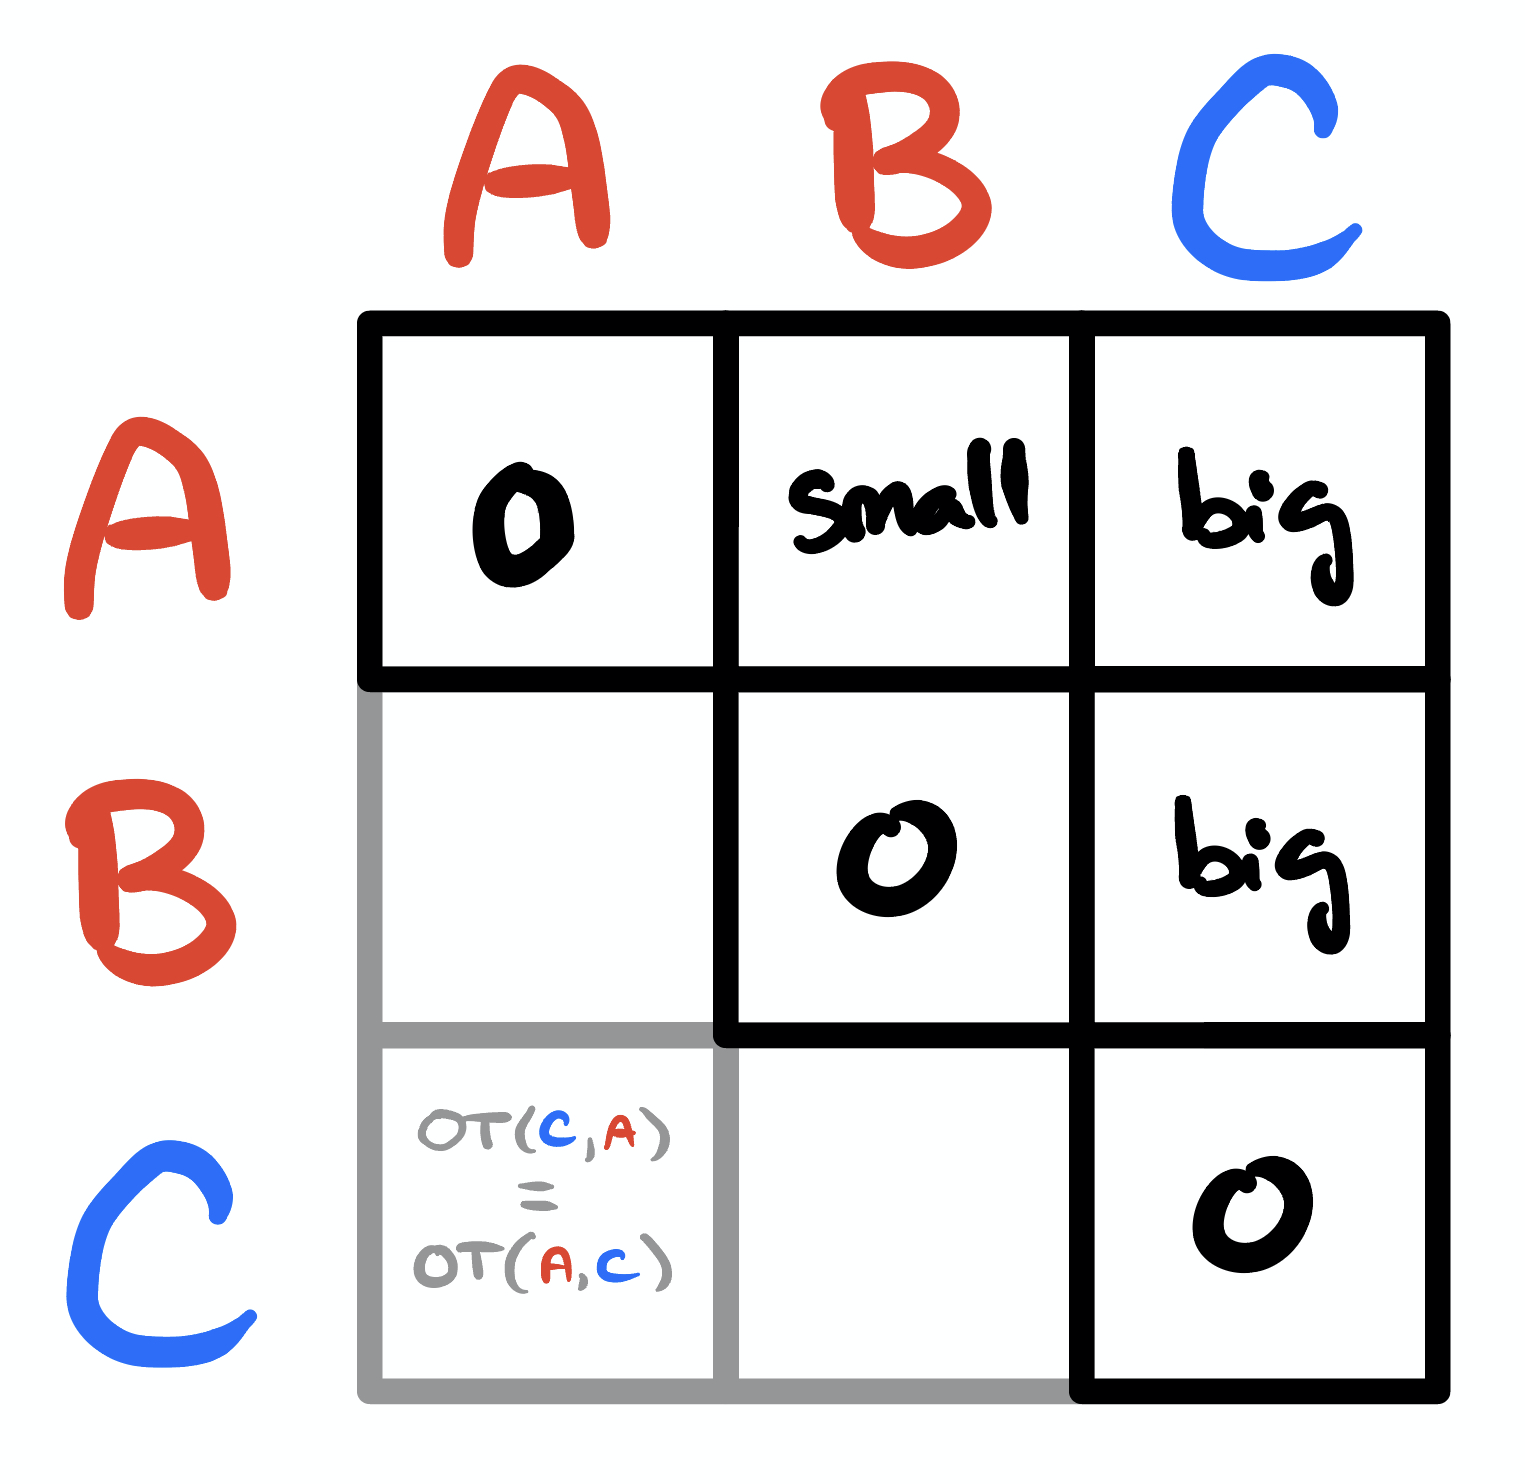

##### **Outline of the idea**

*Step 1:*

We will begin by collecting two sample sets of background events and one sample set from each signal event category: `bkgEvents1, bkgEvents2, [sigEvents, ...]`.

$\color{magenta}{\text{We assume all of the sample sets have the same number of samples:}}$ `nEvents`.

```
# Pseudo code
randomIntegerArray1
randomIntegerArray2
bkgEvents1 = dataDict['bkg']['Particles'][randomIntegerArray1, :, 0:3]
bkgEvents2 = dataDict['bkg']['Particles'][randomIntegerArray2, :, 0:3]

sigEventsList = []
for alias in sigAliasList:
  randomIntegerArray
  sigEvents = dataDict[alias]['Particles'][randomIntegerArray, :, 0:3]
  sigEventsList.append(sigEvents)
```

*Step 2:*

We will then calculate the background-to-background OT distance

```
# Pseudo code
scoreBkg = []
dummyArr = np.arange(nEvents)
for (i,j) in itertools.product(dummyArr, dummyArr):
  scoreBkg.append( OT(bkgEvents1[i], bkgEvents2[j]))
```

Thus, scoreBkg will be an array of `nEvents**2` numbers. NOTE: We could also use the symmetry of OT distances to reduce this slightly: to `(nEvents**2 - nEvents)/2 + nEvents`

*Step 3:*

Using `bkgEvents1` as a reference sample, we'll then calculate the background-to-signal OT distance for each signal type

```
# Pseudo code
scoreSigList = []
for k in range(len(sigAliasList)):
  alias = sigAliasList[k]
  sigEvents = sigEventsList[k]

  scoreSig = []
  dummyArr = np.arange(nEvents)
  for (i,j) in itertools.product(dummyArr, dummyArr):
    scoreSig.append( OT(bkgEvents1[i], sigEvents[j]))
  scoreSigList.append(scoreSig)
```
Thus, each scoreSig will be an array of `nEvents**2` numbers.

*Step 4:*

We can then plot `scoreBkg` against each type of `scoreSig` and calculate the corresponding ROC curve and AUC values.


##### **Some quick notes:**

* Another possibility is to instead to the distribution-to-distribution OT distance calculation rather than the event-to-event.